In [1]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("quora")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

In [2]:
import pandas as pd

df = pd.DataFrame(dataset['train'])
# Extract 'id' and 'text' elements from 'questions' column
df['qid-1'] = df['questions'].apply(lambda x: x['id'][0])
df['qid-2'] = df['questions'].apply(lambda x: x['id'][1])
df['question-1'] = df['questions'].apply(lambda x: x['text'][0])
df['question-2'] = df['questions'].apply(lambda x: x['text'][1])

# Drop the original 'questions' column if needed
df.drop(columns='questions', inplace=True)

# Ensure 'is_duplicate' column is present
# Assuming 'is_duplicate' column is already present, if not, adjust accordingly
# df['is_duplicate'] = ...

# Reorder columns
df = df[['qid-1', 'qid-2', 'question-1', 'question-2', 'is_duplicate']]

# Convert boolean values to integers (True -> 1, False -> 0) in the 'is_duplicate' column
df['is_duplicate'] = df['is_duplicate'].astype(int)

In [3]:
df

,qid-1,qid-2,question-1,question-2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...
404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,537928,537929,What is one coin?,What's this coin?,0
404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, concatenate, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
# Preprocessing
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['question-1'].values + df['question-2'].values)

# Convert text to sequences
X1 = tokenizer.texts_to_sequences(df['question-1'].values)
X2 = tokenizer.texts_to_sequences(df['question-2'].values)

# Padding sequences
max_seq_length = 30
X1 = pad_sequences(X1, maxlen=max_seq_length)
X2 = pad_sequences(X2, maxlen=max_seq_length)

In [6]:
# Labels
y = df['is_duplicate'].values

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

In [7]:
# Siamese LSTM Model
def siamese_lstm_model(input_shape, vocab_size, embedding_dim):
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    embedding_layer = Embedding(vocab_size, embedding_dim)

    lstm_layer = LSTM(128)

    encoded1 = lstm_layer(embedding_layer(input1))
    encoded2 = lstm_layer(embedding_layer(input2))

    merged_vector = concatenate([encoded1, encoded2], axis=-1)
    dense_layer = Dense(128, activation='relu')(merged_vector)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=[input1, input2], outputs=output_layer)

    return model

In [8]:
# Instantiate the model
embedding_dim = 100  # Adjust as needed
vocab_size = len(tokenizer.word_index) + 1
input_shape = (max_seq_length,)
model = siamese_lstm_model(input_shape, vocab_size, embedding_dim)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history = model.fit([X1_train, X2_train], y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/20
4549/4549 [==============================] - 1726s 378ms/step - loss: 0.4787 - accuracy: 0.7684 - val_loss: 0.4300 - val_accuracy: 0.7980
Epoch 2/20
4549/4549 [==============================] - 1736s 382ms/step - loss: 0.3539 - accuracy: 0.8414 - val_loss: 0.4003 - val_accuracy: 0.8221
Epoch 3/20
4549/4549 [==============================] - 1728s 380ms/step - loss: 0.2642 - accuracy: 0.8860 - val_loss: 0.4154 - val_accuracy: 0.8226
Epoch 4/20
4549/4549 [==============================] - 1705s 375ms/step - loss: 0.1987 - accuracy: 0.9175 - val_loss: 0.4513 - val_accuracy: 0.8284
Epoch 5/20
4549/4549 [==============================] - 1716s 377ms/step - loss: 0.1504 - accuracy: 0.9387 - val_loss: 0.4978 - val_accuracy: 0.8241


In [10]:
# Evaluate the model
y_pred = model.predict([X1_test, X2_test])
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

2527/2527 [==============================] - 98s 38ms/step
Test Accuracy: 0.8196962576368448
Test Precision: 0.7348834385624089
Test Recall: 0.8055232074530029
Test F1 Score: 0.7685836283115606


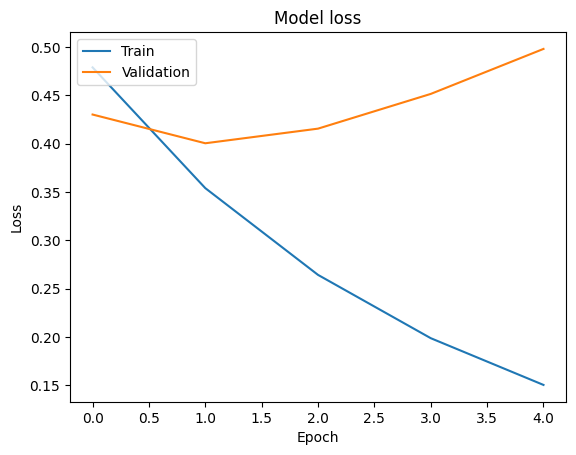

In [12]:
# Plot training & validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

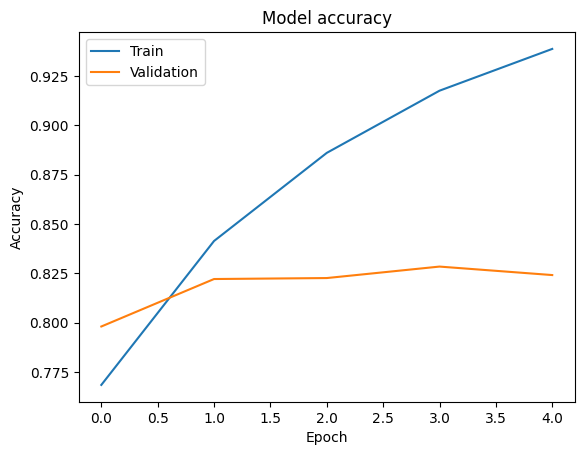

In [13]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

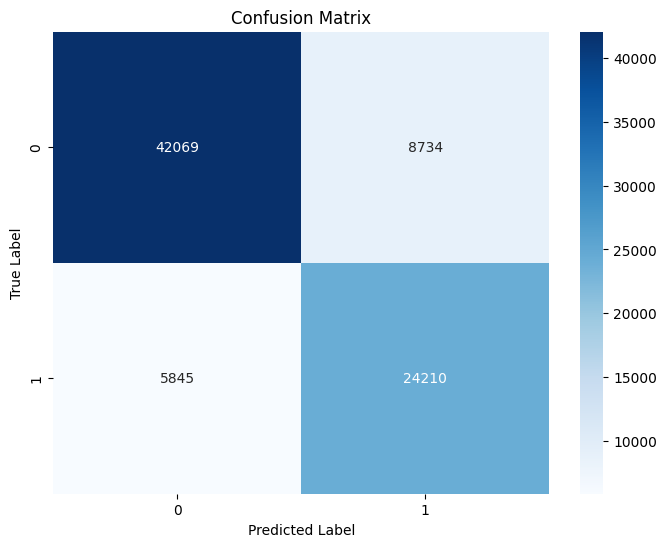

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


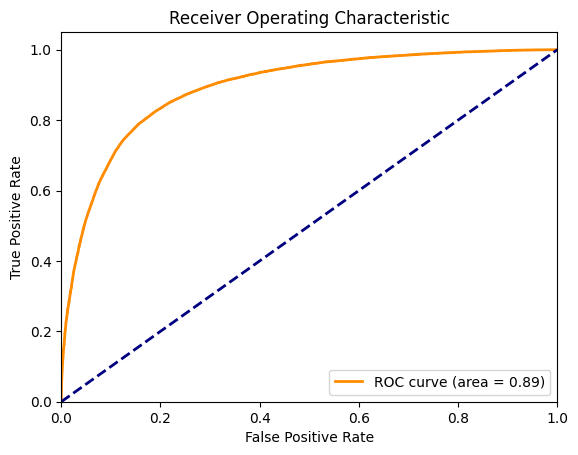

In [15]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


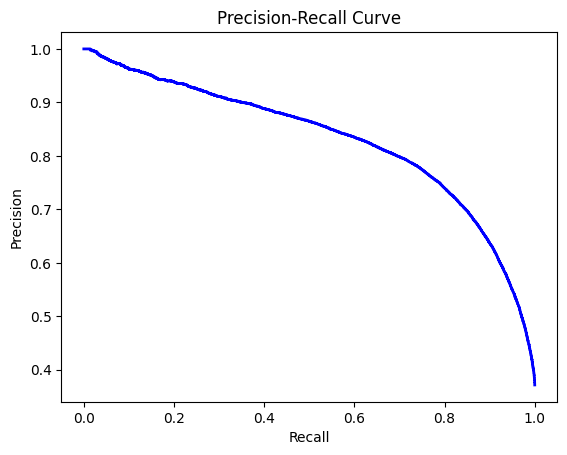

In [16]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [ ]:
def preprocess_text(text, tokenizer, max_seq_length):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_seq_length)
    return padded_sequence

def classify_similarity(text1, text2, model, tokenizer, max_seq_length):
    preprocessed_text1 = preprocess_text(text1, tokenizer, max_seq_length)
    preprocessed_text2 = preprocess_text(text2, tokenizer, max_seq_length)

    similarity_score = model.predict([preprocessed_text1, preprocessed_text2])[0][0]

    return similarity_score

In [18]:
# Save the model to disk
model.save("siamese_lstm_model.h5")

# Download the model file to your local machine
from google.colab import files
files.download("siamese_lstm_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>